# Assessed Coursework Template Notebook

This is the template notebook for the RecSys(H) 2020 coursework. It deals with data preparation and evaluation only.

Please note:
 - use H1 text headings for grouping together blocks of cells. You can then hide these while working on other blocks
 - leave the cell output visible when you submit the notebook



## Setup block

Setup the data files, Python etc.

In [2]:
!rm -rf ratings* books* to_read* test*

!curl -o ratings.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-ratings.csv" 
!curl -o books.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-books.csv"
!curl -o to_read.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-to_read.csv"
!curl -o test.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-test.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7631k  100 7631k    0     0  4763k      0  0:00:01  0:00:01 --:--:-- 4763k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2366k  100 2366k    0     0  2073k      0  0:00:01  0:00:01 --:--:-- 2072k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7581k  100 7581k    0     0  6164k      0  0:00:01  0:00:01 --:--:-- 6164k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1895k  100 1895k    0     0  1358k      0  0:00:01  0:00:01 --:--:-- 1358k


In [3]:
#Standard setup
import pandas as pd
import numpy as np
import torch
!pip install git+https://github.com/cmacdonald/spotlight.git@master#egg=spotlight
from spotlight.interactions import Interactions


  Cloning https://github.com/cmacdonald/spotlight.git (to revision master) to /tmp/pip-install-i9_0imkz/spotlight
  Running command git clone -q https://github.com/cmacdonald/spotlight.git /tmp/pip-install-i9_0imkz/spotlight
  Created wheel for spotlight: filename=spotlight-0.1.6-cp36-none-any.whl size=34096 sha256=fa7798c59e606d9f2ed83e26096e2c51800cd414648bbb9f1d17f3bc4bb274cb
  Stored in directory: /tmp/pip-ephem-wheel-cache-pyxvktwg/wheels/22/6f/f1/68cc6c5b563e78737e4a8fed63ddc105a3baf25d2abccae0c6
Successfully built spotlight


# data preparation

In [0]:
#load in the csv files
ratings_df = pd.read_csv("ratings.csv")
books_df = pd.read_csv("books.csv")
to_read_df = pd.read_csv("to_read.csv")
test = pd.read_csv("test.csv")

In [0]:
#cut down the number of items and users
counts=ratings_df[ratings_df["book_id"] < 2000].groupby(["book_id"]).count().reset_index()
valid_books=counts[counts["user_id"] >= 10][["book_id"]]

books_df = books_df.merge(valid_books, on="book_id")

ratings_df = ratings_df[ratings_df["user_id"] < 2000].merge(valid_books, on="book_id")
to_read_df = to_read_df[to_read_df["user_id"] < 2000].merge(valid_books, on="book_id")
test = test[test["user_id"] < 2000].merge(valid_books, on="book_id")


Here we construct the Interactions objects from `ratings.csv`, `to_read.csv` and `test.csv`. We manually specify the num_users and num_items parameters to all Interaction objects, in case the test set differs from your training sets.

In [6]:
from collections import defaultdict
from itertools import count

from spotlight.cross_validation import random_train_test_split

iid_map = defaultdict(count().__next__)
rating_iids = np.array([iid_map[iid] for iid in ratings_df["book_id"].values], dtype = np.int32)
test_iids = np.array([iid_map[iid] for iid in test["book_id"].values], dtype = np.int32)
toread_iids = np.array([iid_map[iid] for iid in to_read_df["book_id"].values], dtype = np.int32)


uid_map = defaultdict(count().__next__)
test_uids = np.array([uid_map[uid] for uid in test["user_id"].values], dtype = np.int32)
rating_uids = np.array([uid_map[uid] for uid in ratings_df["user_id"].values], dtype = np.int32)
toread_uids = np.array([uid_map[iid] for iid in to_read_df["user_id"].values], dtype = np.int32)


uid_rev_map = {v: k for k, v in uid_map.items()}
iid_rev_map = {v: k for k, v in iid_map.items()}


rating_dataset = Interactions(user_ids=rating_uids,
                               item_ids=rating_iids,
                               ratings=ratings_df["rating"].values,
                               num_users=len(uid_rev_map),
                               num_items=len(iid_rev_map))

toread_dataset = Interactions(user_ids=toread_uids,
                               item_ids=toread_iids,
                               num_users=len(uid_rev_map),
                               num_items=len(iid_rev_map))

test_dataset = Interactions(user_ids=test_uids,
                               item_ids=test_iids,
                               num_users=len(uid_rev_map),
                               num_items=len(iid_rev_map))

print(rating_dataset)
print(toread_dataset)
print(test_dataset)

#here we define the validation set
#toread_dataset_train, validation = random_train_test_split(toread_dataset, random_state=np.random.seed(42))
toread_dataset_train, validation = random_train_test_split(toread_dataset, random_state=np.random.RandomState(42))
num_items = test_dataset.num_items
num_users = test_dataset.num_users

<Interactions dataset (1999 users x 1826 items x 124762 interactions)>
<Interactions dataset (1999 users x 1826 items x 135615 interactions)>
<Interactions dataset (1999 users x 1826 items x 33917 interactions)>


#Example code

To evaluate soem of your hand-implemented recommender systems (e.g. Q1, Q4), you will need to instantiate objects that match the specification of a Spotlight model, which `mrr_score()` expects.


Here is an example recommender object that returns 0 for each item, regardless of user.

In [7]:
from spotlight.evaluation import mrr_score


class dummymodel:
  
  def __init__(self, numitems):
    self.predictions=np.zeros(numitems)
  
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
    #this model returns all zeros, regardless of userid
    return( self.predictions )

#lets evaluate how the effeciveness of dummymodel

print(mrr_score(dummymodel(num_items), test_dataset, train=rating_dataset, k=100).mean())
#as expected, a recommendation model that gives 0 scores for all items obtains a MRR score of 0



0.0


In [8]:

#note that the latest copy of Craig's Spotlight displays a progress bar if you set verbose=True
print(mrr_score(dummymodel(num_items), test_dataset, train=rating_dataset, k=100, verbose=True).mean())


1999it [00:00, 2952.89it/s]

0.0


In [0]:
test

#Q1


In [71]:
from spotlight.evaluation import mrr_score

class averageRating:
  
  def __init__(self, numitems):
    self.predictions= ratings_df.groupby(ratings_df['book_id']).mean().reset_index()['rating']
  
  def predict(self, uid):
    return (self.predictions)

print(mrr_score(averageRating(num_items), test_dataset).mean())

0.011335079304358063


In [10]:
print(books_df['original_title'].loc[to_read_df["user_id"] == 1])

Series([], Name: original_title, dtype: object)


In [11]:
class ratingCount:
  
  def __init__(self, numitems):
    self.predictions=books_df.sort_values('ratings_count', ascending=True)['book_id']
  
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):

    #this model returns all zeros, regardless of userid
    return (self.predictions)

#lets evaluate how the effeciveness of dummymodel

ratingCount = mrr_score(ratingCount(num_items), test_dataset).mean()
print(ratingCount)
#as expected, a recommendation model that gives 0 scores for all items obtains a MRR score of 0


0.06652234847582521


In [12]:
class fiveStarRating:
  
  def __init__(self, numitems):
     self.predictions=books_df.sort_values('ratings_5', ascending=True)['book_id']
  
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):

    #this model returns all zeros, regardless of userid
    return (self.predictions)

#lets evaluate how the effeciveness of dummymodel

print(mrr_score(fiveStarRating(num_items), test_dataset).mean())
#as expected, a recommendation model that gives 0 scores for all items obtains a MRR score of 0

0.0706889158865147


In [13]:
class fracOfFiveStarRating:
  
  def __init__(self, numitems):
    fiveS_R = np.array(books_df.sort_values('ratings_5', ascending=True)['book_id'])
    rating_c = np.array(books_df.sort_values('ratings_count', ascending=True)['book_id'])
    self.predictions=np.divide(fiveS_R, rating_c)
  
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):

    #this model returns all zeros, regardless of userid
    return (self.predictions)

#lets evaluate how the effeciveness of dummymodel

print(mrr_score(fracOfFiveStarRating(num_items), test_dataset).mean())
#as expected, a recommendation model that gives 0 scores for all items obtains a MRR score of 0

0.01890191127309687


In [0]:
rating_dataset_train, rating_validation = random_train_test_split(rating_dataset, random_state=np.random.RandomState(42))

In [33]:
from spotlight.factorization.explicit import ExplicitFactorizationModel
import time  

latent_factors = [8,16,32,64]

for latent_factor in latent_factors:
  emodel = ExplicitFactorizationModel(n_iter=5, embedding_dim=latent_factor, random_state=np.random.RandomState(1))
  current = time.time()

  emodel.fit(rating_dataset_train, verbose=True)

  end = time.time()
  diff = end - current
  print("Training took %d seconds "% (diff))
  print(mrr_score(emodel, rating_validation, train=rating_dataset_train).mean())


Epoch 0: loss 6.852240679508601
Epoch 1: loss 0.8537795037795336
Epoch 2: loss 0.7273159543673198
Epoch 3: loss 0.6822295100261003
Epoch 4: loss 0.6443206302630595
Training took 6 seconds 
0.027137973748779153
Epoch 0: loss 5.486129596752998
Epoch 1: loss 0.8041121728909322
Epoch 2: loss 0.6929380716421665
Epoch 3: loss 0.6088081004527899
Epoch 4: loss 0.5440075484605936
Training took 6 seconds 
0.023598108578098572
Epoch 0: loss 4.63195909735484
Epoch 1: loss 0.8125760692816514
Epoch 2: loss 0.6367778570224077
Epoch 3: loss 0.489212008470144
Epoch 4: loss 0.39298825714832697
Training took 10 seconds 
0.0395703804283094
Epoch 0: loss 4.222629998738949
Epoch 1: loss 0.7687427204388838
Epoch 2: loss 0.49041887819767
Epoch 3: loss 0.34664548280147406
Epoch 4: loss 0.29705566125802507
Training took 11 seconds 
0.037427046856761716


In [36]:
from spotlight.factorization.explicit import ExplicitFactorizationModel
import time  
emodel = ExplicitFactorizationModel(n_iter=5, embedding_dim=32, random_state=np.random.RandomState(1))
current = time.time()
emodel.fit(rating_dataset_train, verbose=True)
end = time.time()
diff = end - current
print("Training took %d seconds "% (diff))
print(mrr_score(emodel, test_dataset, train=rating_dataset_train).mean())

Epoch 0: loss 4.63195909735484
Epoch 1: loss 0.8125760692816514
Epoch 2: loss 0.6367778570224077
Epoch 3: loss 0.489212008470144
Epoch 4: loss 0.39298825714832697
Training took 9 seconds 
0.05402085963616729


In [38]:
from spotlight.factorization.implicit import ImplicitFactorizationModel
import time  
latent_factors = [8,16,32,64]

for latent_factor in latent_factors:
  imodel = ImplicitFactorizationModel(n_iter=5, loss='bpr', embedding_dim=latent_factor, random_state=np.random.RandomState(1))
  current = time.time()

  imodel.fit(rating_dataset_train, verbose=True)

  end = time.time()
  diff = end - current
  print("Training took %d seconds "% (diff))
  print(mrr_score(imodel, rating_validation, train=rating_dataset_train).mean())
  print(mrr_score(imodel, rating_validation).mean())



Epoch 0: loss 0.3985566278298696
Epoch 1: loss 0.24925577029203758
Epoch 2: loss 0.19070154290932875
Epoch 3: loss 0.1704374448229105
Epoch 4: loss 0.15779437380723463
Training took 11 seconds 
0.27890790633411944
0.19125078412221985
Epoch 0: loss 0.36774481981992724
Epoch 1: loss 0.21139488021532696
Epoch 2: loss 0.1733851354282636
Epoch 3: loss 0.1555090199296291
Epoch 4: loss 0.14204624140491853
Training took 12 seconds 
0.28041758974725456
0.19008512192604238
Epoch 0: loss 0.34449376723705194
Epoch 1: loss 0.19189196278651555
Epoch 2: loss 0.1546030117151065
Epoch 3: loss 0.1375689512835099
Epoch 4: loss 0.1251786368397566
Training took 17 seconds 
0.29615541897933095
0.1982030697888627
Epoch 0: loss 0.3287767251332601
Epoch 1: loss 0.177439079586512
Epoch 2: loss 0.13962622773952973
Epoch 3: loss 0.12147386717872742
Epoch 4: loss 0.10678537526191809
Training took 19 seconds 
0.2870834226637128
0.17734740386066047


In [42]:
from spotlight.factorization.implicit import ImplicitFactorizationModel
import time  
imodel_best1 = ImplicitFactorizationModel(n_iter=5, loss='bpr', embedding_dim=32, random_state=np.random.RandomState(1))
current = time.time()
imodel_best1.fit(rating_dataset_train, verbose=True)
end = time.time()
diff = end - current
print("Training took %d seconds "% (diff))
imodel_best1_mrr=mrr_score(imodel_best1, test_dataset, train=rating_dataset_train).mean()
print(imodel_best1_mrr)


Epoch 0: loss 0.34449376723705194
Epoch 1: loss 0.19189196278651555
Epoch 2: loss 0.1546030117151065
Epoch 3: loss 0.1375689512835099
Epoch 4: loss 0.1251786368397566
Training took 17 seconds 
0.34979116542398186


In [43]:
from spotlight.factorization.implicit import ImplicitFactorizationModel
import time  
latent_factors = [8,16,32,64]
for latent_factor in latent_factors:
  imodelBPR = ImplicitFactorizationModel(n_iter=5, loss='bpr', embedding_dim=latent_factor, random_state=np.random.RandomState(1))
  current = time.time()

  imodelBPR.fit(toread_dataset_train, verbose=True)

  end = time.time()
  diff = end - current
  print("Training took %d seconds "% (diff))
  print(mrr_score(imodelBPR, validation, train=toread_dataset_train).mean()) 

Epoch 0: loss 0.39337800112816523
Epoch 1: loss 0.24179184918274294
Epoch 2: loss 0.19207951633857107
Epoch 3: loss 0.17463349203034392
Epoch 4: loss 0.16280447224260503
Training took 12 seconds 
0.28628004478429686
Epoch 0: loss 0.35834955793084966
Epoch 1: loss 0.2094157070694667
Epoch 2: loss 0.17453473395193522
Epoch 3: loss 0.15932149856509464
Epoch 4: loss 0.14717754435215918
Training took 12 seconds 
0.29981260471505594
Epoch 0: loss 0.3424184679774181
Epoch 1: loss 0.19521144282002495
Epoch 2: loss 0.16036324589601103
Epoch 3: loss 0.14363892933459216
Epoch 4: loss 0.1304559223529584
Training took 19 seconds 
0.2977478818774467
Epoch 0: loss 0.32598371304712204
Epoch 1: loss 0.18099869759577625
Epoch 2: loss 0.14648431298797424
Epoch 3: loss 0.1284485306098776
Epoch 4: loss 0.11467573814586086
Training took 21 seconds 
0.29401506308709907


In [57]:
from spotlight.factorization.implicit import ImplicitFactorizationModel
import time  
imodel_best2 = ImplicitFactorizationModel(n_iter=5, loss='bpr', embedding_dim=16, random_state=np.random.RandomState(1))
current = time.time()
imodel_best2.fit(toread_dataset_train, verbose=True)
end = time.time()
diff = end - current
print("Training took %d seconds "% (diff))
imodel_best2_mrr = mrr_score(imodel_best2, test_dataset, train=toread_dataset_train).mean()
print(imodel_best2_mrr)

Epoch 0: loss 0.35834955793084966
Epoch 1: loss 0.2094157070694667
Epoch 2: loss 0.17453473395193522
Epoch 3: loss 0.15932149856509464
Epoch 4: loss 0.14717754435215918
Training took 13 seconds 
0.3376630775705313


In [0]:
import scipy.stats as st
import torch.nn as nn

In [102]:
len(toread_iids[toread_uids==1])

96

In [101]:
len(test_iids[test_uids==1])

18

In [149]:
import scipy.stats as st
rrs = mrr_score(imodel_best2, test_dataset)
RR_ranks = st.rankdata(-rrs, method='min')
def countRatings(uid, rr):  
  print("User with id %d with RR %f had %d books" %( uid, rr, len(toread_iids[toread_uids==uid])))
  print("User with id %d with RR %f has %d more ratings from test_dataset" %( uid, rr, len(test_iids[test_uids==uid])))

countRatings( np.argwhere(RR_ranks==1).item(0), rrs[RR_ranks==1].item(0) )




User with id 1 with RR 1.000000 had 96 books
User with id 1 with RR 1.000000 has 18 more ratings from test_dataset


In [0]:
books_1 = books_df['book_id'].loc[toread_iids[toread_uids==1]]
books_2 = books_df['book_id'].loc[test_iids[test_uids==1]]
books_2


In [0]:
#this method predics the top five book items for the given user
 
def tracksForUser(user, k=5):
  ranks = st.rankdata(-imodel_best2.predict(user))  
  for iid in np.argwhere(ranks <= k):
    print(iid_rev_map[iid.item(0)], books_df['original_title'].loc[books_df['book_id']==iid_rev_map[iid.item(0)]])
 
tracksForUser(2)

In [60]:
#this method calculate the cosine similarity and ILD 

def mostsimilar(targetBookId, model):
  highest=0
  highestCos=0
  highestCos_ild =0
  targetIId=iid_map.get(targetBookId)

  for x in range(0,model._num_items):
    if x != targetIId:
      cosine = nn.functional.cosine_similarity(
            model._net.item_embeddings.weight[targetIId], 
          model._net.item_embeddings.weight[x], 
          dim=0)
      if cosine > highestCos:
        highest = x
        highestCos = cosine
        highestCos_ild += 1 - highestCos
        ild = highestCos_ild / (5*(5-1))
        
  print(ild)  

  print(cosine.data) 
  

  print(toread_dataset_train.num_items)
  print("targetMovieId = %d (iid %d)" % (targetBookId, targetIId))
  print(books_df['original_title'].loc[books_df['book_id']==targetBookId])
  print("mostSimilar = %d (iid %d) with cosine of %f " % ( iid_rev_map.get(highest), highest, highestCos))
  print(books_df['original_title'].loc[books_df['book_id']==iid_rev_map.get(highest)])
  
mostsimilar(60, imodel_best2)

tensor(0.0368, grad_fn=<DivBackward0>)
tensor(-0.5993)
1826
targetMovieId = 60 (iid 77)
59    The Curious Incident of the Dog in the Night-Time
Name: original_title, dtype: object
mostSimilar = 45 (iid 25) with cosine of 0.950975 
44    Life of Pi
Name: original_title, dtype: object


In [141]:
#This is a combined method of above two function 
#i.e getting top 5 rank book items and calculating similarity with ILD score

def mostsimilar(user, r=5):
  highest=0
  highestCos=0
  highestCos_ild =0
  
  #this will give the top 5 items for given user.
  ranks = st.rankdata(-imodel_best2.predict(user)) 
  for iid in np.argwhere(ranks <= r):
    targetBookId = iid_rev_map[iid.item(0)]
    targetIId = iid_map.get(targetBookId)

   #nn.functional.cosine_similarity() allows you to calculate the cosine similarity between two vectors. 
    for x in range(0,imodel_best2._num_items):
      if x!= targetIId:
        cosine = nn.functional.cosine_similarity(imodel_best2._net.item_embeddings.weight[targetIId], 
          imodel_best2._net.item_embeddings.weight[x], 
          dim=0)
      if cosine > highestCos:
        highest = x
        highestCos = cosine
    highestCos_ild += 1 - highestCos
   
    print(cosine.data)
    print(highestCos_ild)
    print("targetBookId = %d (iid %d)" % (targetBookId, targetIId), books_df['original_title'].loc[books_df['book_id']==targetBookId])
    print("mostSimilar = %d (iid %d) with cosine of %f " % ( iid_rev_map.get(highest), highest, highestCos), books_df['original_title'].loc[books_df['book_id']==iid_rev_map.get(highest)] )
    print('-----')
    highestCos = 0
  ild = highestCos_ild / (r*(r-1))
  print(ild)
  print(toread_dataset_train.num_items)
  
  
mostsimilar(5)

tensor(-0.7231)
tensor(0.0492, grad_fn=<AddBackward0>)
targetBookId = 5 (iid 21) 4    The Great Gatsby
Name: original_title, dtype: object
mostSimilar = 4 (iid 108) with cosine of 0.950816  3    To Kill a Mockingbird
Name: original_title, dtype: object
-----
tensor(-0.7250)
tensor(0.1182, grad_fn=<AddBackward0>)
targetBookId = 8 (iid 23) 7    The Catcher in the Rye
Name: original_title, dtype: object
mostSimilar = 233 (iid 104) with cosine of 0.931017  232    El amor en los tiempos del cólera
Name: original_title, dtype: object
-----
tensor(-0.8597)
tensor(0.1689, grad_fn=<AddBackward0>)
targetBookId = 65 (iid 24) 64    Slaughterhouse-Five, or The Children's Crusade...
Name: original_title, dtype: object
mostSimilar = 83 (iid 354) with cosine of 0.949221  82    A Tale of Two Cities
Name: original_title, dtype: object
-----
tensor(-0.8734)
tensor(0.2118, grad_fn=<AddBackward0>)
targetBookId = 14 (iid 33) 13    Animal Farm: A Fairy Story
Name: original_title, dtype: object
mostSimilar = 

In [177]:
class Combsum:

  def __init__(self, numitems):
    #self.predictions=imodel_best1.predict(num_items) + imodel_best2.predict(num_items)
    self.predictions=np.zeros(numitems)
  
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
   
   return imodel_best1.predict(uid) + imodel_best2.predict(uid)
   #return (imodel_best1.predict(np.array([uid])) + imodel_best2.predict(np.array([uid]))) 

#lets evaluate how the effeciveness of dummymodel

combsum_model=mrr_score(Combsum(num_items), test_dataset).mean()
print(combsum_model)

#as expected, a recommendation model that gives 0 scores for all items obtains a MRR score of 0

0.2387177715842048


In [178]:
print(combsum_model)

0.2387177715842048


592

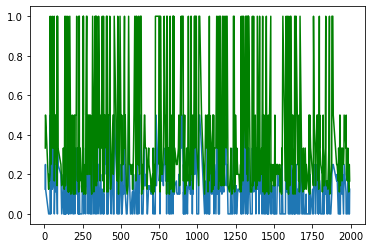

In [84]:
import scipy.stats as st
import matplotlib.pyplot as plt

best_model = mrr_score(imodel_best2, test_dataset)
combsum_model = mrr_score(Combsum(num_items), test_dataset)

uids= []
y = []
x = []
for uid in np.argwhere(best_model < combsum_model):
  if(best_model[uid] < combsum_model[uid]):
    y.append(best_model[uid].item(0))
    x.append(combsum_model[uid].item(0))
  uids.append(uid.item(0))

plt.plot(uids, y)
plt.plot(uids, x, color='g')
len(uids)

In [64]:
positives=ratings_df[ratings_df["rating"]>=4]

#join positives with itself on userId to get all pairs of movies watched by a given user.

pairs=pd.merge(positives, positives, on=["user_id"])


#lets count the frequency of each pair of movies.
paircounts=pairs[["book_id_x", "book_id_y", "user_id"]].groupby(["book_id_x", "book_id_y"]).count()

#sort by the most popular pairs.
pairswithcounts = paircounts.reset_index().rename(columns={"user_id" : "count"}).sort_values(['count'], ascending=False)

#display the top most frequent pairs
pairswithcounts.head()

,book_id_x,book_id_y,count
4728,4,4,528
0,1,1,502
36660,25,25,453
25867,18,18,414
10882,8,8,408


In [65]:
##Solution



# pairswithcounts gives is the frequency of (X AND Y). 

#We therefore need the counts of movies
bookCounts = positives.groupby(["book_id"]).count()[["user_id"]].reset_index().rename(columns={"user_id" : "ratingCount"})

#lets puts all the information in the sample dataframe.
allstats = pairswithcounts.merge(bookCounts, left_on="book_id_x", right_on="book_id").merge(bookCounts, left_on="book_id_y", right_on="book_id")

#and drop out some unused columns
allstats = allstats[["book_id_x",	"book_id_y",	"count", "ratingCount_x", "ratingCount_y"]]
allstats = allstats.loc[:,~allstats.columns.duplicated()]

#to calculate probabilites we need a denominator. I used the number of total ratings
num=float(ratings_df.count()["rating"])

#we can then perform artihmetic on columns
allstats["lift"] = (allstats["count"] / num ) / ( (allstats["ratingCount_x"] / num) * (allstats["ratingCount_y"] / num))

#and finally, merge in the titles
withtitles = allstats.merge(books_df, left_on=["book_id_x"], right_on="book_id").merge(books_df, left_on=["book_id_y"], right_on="book_id")

withtitles.sort_values(['lift'], ascending=False)

#note that some of the movies with highlest lift have very low frequencies. We would apply a minium support threshold


,book_id_x,book_id_y,count,ratingCount_x,ratingCount_y,lift,Unnamed: 0_x,book_id_x,goodreads_book_id_x,best_book_id_x,work_id_x,books_count_x,isbn_x,isbn13_x,authors_x,original_publication_year_x,original_title_x,title_x,language_code_x,average_rating_x,ratings_count_x,work_ratings_count_x,work_text_reviews_count_x,ratings_1_x,ratings_2_x,ratings_3_x,ratings_4_x,ratings_5_x,image_url_x,small_image_url_x,Unnamed: 0_y,book_id_y,goodreads_book_id_y,best_book_id_y,work_id_y,books_count_y,isbn_y,isbn13_y,authors_y,original_publication_year_y,original_title_y,title_y,language_code_y,average_rating_y,ratings_count_y,work_ratings_count_y,work_text_reviews_count_y,ratings_1_y,ratings_2_y,ratings_3_y,ratings_4_y,ratings_5_y,image_url_y,small_image_url_y
1078827,1840,1840,1,1,1,124762.000000,1839,1840,84136,84136,2384,49,312979975,9.780313e+12,Sherrilyn Kenyon,2002.0,Fantasy Lover,Fantasy Lover (Dark-Hunterverse #1),eng,4.17,70274,74975,3081,1409,3288,12339,22030,35909,https://images.gr-assets.com/books/1348332807m...,https://images.gr-assets.com/books/1348332807s...,1839,1840,84136,84136,2384,49,312979975,9.780313e+12,Sherrilyn Kenyon,2002.0,Fantasy Lover,Fantasy Lover (Dark-Hunterverse #1),eng,4.17,70274,74975,3081,1409,3288,12339,22030,35909,https://images.gr-assets.com/books/1348332807m...,https://images.gr-assets.com/books/1348332807s...
1078733,1227,1227,1,1,1,124762.000000,1226,1227,5391115,5391115,4115339,44,61662763,9.780062e+12,Kelley Armstrong,2009.0,The Awakening,"The Awakening (Darkest Powers, #2)",eng,4.16,95026,98240,3118,1151,3775,17773,31477,44064,https://images.gr-assets.com/books/1478986806m...,https://images.gr-assets.com/books/1478986806s...,1226,1227,5391115,5391115,4115339,44,61662763,9.780062e+12,Kelley Armstrong,2009.0,The Awakening,"The Awakening (Darkest Powers, #2)",eng,4.16,95026,98240,3118,1151,3775,17773,31477,44064,https://images.gr-assets.com/books/1478986806m...,https://images.gr-assets.com/books/1478986806s...
1078094,1523,1523,1,1,1,124762.000000,1522,1523,8525590,8525590,13392566,44,1442409053,9.781442e+12,Lauren DeStefano,2011.0,Wither,"Wither (The Chemical Garden, #1)",eng,3.81,84776,88657,7886,3105,7449,20924,28676,28503,https://images.gr-assets.com/books/1341532430m...,https://images.gr-assets.com/books/1341532430s...,1522,1523,8525590,8525590,13392566,44,1442409053,9.781442e+12,Lauren DeStefano,2011.0,Wither,"Wither (The Chemical Garden, #1)",eng,3.81,84776,88657,7886,3105,7449,20924,28676,28503,https://images.gr-assets.com/books/1341532430m...,https://images.gr-assets.com/books/1341532430s...
1078792,418,418,1,1,1,124762.000000,417,418,6479259,6479259,6670482,71,1595142509,9.781595e+12,Richelle Mead,2010.0,Spirit Bound,"Spirit Bound (Vampire Academy, #5)",eng,4.37,224247,235076,8030,2755,5907,26981,66097,133336,https://images.gr-assets.com/books/1291168967m...,https://images.gr-assets.com/books/1291168967s...,417,418,6479259,6479259,6670482,71,1595142509,9.781595e+12,Richelle Mead,2010.0,Spirit Bound,"Spirit Bound (Vampire Academy, #5)",eng,4.37,224247,235076,8030,2755,5907,26981,66097,133336,https://images.gr-assets.com/books/1291168967m...,https://images.gr-assets.com/books/1291168967s...
1078791,1416,418,1,1,1,124762.000000,1415,1416,8709523,8709523,13582370,35,1595143181,9.781595e+12,Richelle Mead,2012.0,The Golden Lily,"The Golden Lily (Bloodlines, #2)",en-US,4.36,86929,91787,6026,688,1779,10687,29356,49277,https://images.gr-assets.com/books/1360599818m...,https://images.gr-assets.com/books/1360599818s...,417,418,6479259,6479259,6670482,71,1595142509,9.781595e+12,Richelle Mead,2010.0,Spirit Bound,"Spirit Bound (Vampire Academy, #5)",eng,4.37,224247,235076,8030,2755,5907,26981,66097,133336,https://images.gr-assets.com/books/1291168967m...,https://images.gr-assets.com/books/1291168967s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [173]:
class HRS_Model:
  
  def __init__(self, numitems):
    self.predictions=np.zeros(numitems)
  
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
    w1 = 0.05
    w2 = 0.075
    w3 = 0.03

    return ((averageRating(averageRating).predict(uid)*w1)+(imodel_best1.predict(uid)*w2)+(imodel_best2.predict(uid)*w3))
  

print(mrr_score(HRS_Model(num_items), validation).mean())
#as expected, a recommendation model that gives 0 scores for all items obtains a MRR score of 0


0.22613985564210679


In [170]:
class HRS_Model:
  
  def __init__(self, numitems):
    self.predictions=np.zeros(numitems)
  
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
    w1 = 0.1
    w2 = 0.2
    w3 = 0.3 
    return ((averageRating(averageRating).predict(uid)*w1)+(imodel_best1.predict(uid)*w2)+(imodel_best2.predict(uid)*w3))
  

print(mrr_score(HRS_Model(num_items), validation).mean())
#as expected, a recommendation model that gives 0 scores for all items obtains a MRR score of 0

0.21540631426824525


In [174]:
class HRS_Model:
  
  def __init__(self, numitems):
    self.predictions=np.zeros(numitems)
  
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
    w1 =0.3
    w2 = 0.4
    w3 = 0.5 
    return ((averageRating(averageRating).predict(uid)*w1)+(imodel_best1.predict(uid)*w2)+(imodel_best2.predict(uid)*w3))
  

print(mrr_score(HRS_Model(num_items), validation).mean())
#as expected, a recommendation model that gives 0 scores for all items obtains a MRR score of 0

0.21687708933831998


In [176]:
class HRS_Model:
  
  def __init__(self, numitems):
    self.predictions=np.zeros(numitems)
  
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
    w1 = 0.05
    w2 = 0.075
    w3 = 0.03

    return ((averageRating(averageRating).predict(uid)*w1)+(imodel_best1.predict(uid)*w2)+(imodel_best2.predict(uid)*w3))
  

print(mrr_score(HRS_Model(num_items), test_dataset).mean())
#as expected, a recommendation model that gives 0 scores for all items obtains a MRR score of 0


0.23632649658162413
